In [9]:
import os
import gc
from random import choice

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import rankdata

from mlopt.blending import BlendingGreedyTransformer

from preprocessing import preprocessing_gbdt_models, preprocessing_linear_models
from feature_engineering import run_feature_engineering
import config
import models

sns.set()

In [ ]:
run_feature_engineering()

# LightGBM

In [3]:
data = pd.read_feather('data/data.feather')
test = pd.read_feather('data/test.feather')

y = models.get_y_train()

data, test = preprocessing_gbdt_models(data=data, test=test)

models.run_lightgbm(data, y, test)

# Denoising Autoencoder

In [3]:
data = pd.read_feather('data/data.feather')
test = pd.read_feather('data/test.feather')

data, test = preprocessing_linear_models(data=data, test=test)

data.to_feather('predictions/X_train_scaled.feather')
test.to_feather('predictions/X_test_scaled.feather')

del data, test
gc.collect()

269  flag columns
Shapes :  (307511, 867) (48744, 867)


In [46]:
X_train_scaled = pd.read_feather('predictions/X_train_scaled.feather')
X_test_scaled = pd.read_feather('predictions/X_test_scaled.feather')

epochs=300
noise_begin=0.6
noise_end=0.1
noise_reduce_epoch=200
noise_reduce_end_epoch=epochs

nodes_1 = 1000
nodes_2 = 1000
nodes_3 = 1000

learning_rate= 0.001

X_train_activations, X_test_activations, scores = \
    run_autoencoder(X_train_scaled, X_test_scaled, nodes_1, nodes_2, nodes_3, 
                    learning_rate=learning_rate, epochs=epochs,
                    noise_begin=noise_begin, noise_end=noise_end, 
                    noise_reduce_epoch=noise_reduce_epoch,
                    noise_reduce_end_epoch=noise_reduce_end_epoch)

X_train_activations, X_test_activations = \
    models.postprocess_autoencoder(X_train_activations, X_test_activations,
                                   X_train_scaled, X_test_scaled)
    
X_train_activations.to_feather('train_activations.feather')
X_test_activations.to_feather('test_activations.feather')

noise reduce after epoch 200: 0.005
Shape:  (307511, 875)
Starting training...
Initialization finished...

Epoch 0 	MSE: 0.02500, layer_1_2 score:0.7480, noise: 0.60
Epoch 1 	MSE: 0.02136, layer_1_2 score:0.7481, noise: 0.60
Epoch 50 	MSE: 0.01814, layer_1_2 score:0.7457, noise: 0.60
Epoch 100 	MSE: 0.01802, layer_1_2 score:0.7474, noise: 0.60
Epoch 150 	MSE: 0.01796, layer_1_2 score:0.7454, noise: 0.60
Epoch 200 	MSE: 0.01768, layer_1_2 score:0.7351, noise: 0.59
Epoch 250 	MSE: 0.00898, layer_1_2 score:0.7696, noise: 0.34
Epoch 299 	MSE: 0.00322, layer_1_2 score:0.7734, noise: 0.10
Finished


## Neural net

In [43]:
X_train_activations = pd.read_feather('data/train_activations.feather')
X_test_activations = pd.read_feather('data/test_activations.feather')

In [ ]:
n_splits = 10

dl_params = {'units_1': 500, 'units_2': 500, 'units_3': None, 'opt': 'ftrl', 
             'learning_rate': 0.01, 'batch_size_multiplier': 2, 'lambda_l2': 0.001,
             'layer_0_dropout': 0.0, 'layer_1_dropout': 0.6, 
             'layer_2_dropout': 0.2,  'layer_3_dropout': 0.0}

models.run_nn(X_train=X_train_activations, y_train=y, X_test=X_test_activations, 
                  n_runs=10, **dl_params)

## LightGBM

In [48]:
df_train_activations = pd.read_feather('data/train_activations.feather')
df_test_activations = pd.read_feather('data/test_activations.feather')

y_train = pd.read_csv(path + 'application_train.csv.zip').TARGET

models.run_dae_lightgbm(df_train_activations, y_train, df_test_activations, 
                        learning_rate=0.02, bagging_fraction=0.8, feature_fraction=0.6
                        lambda_l1=0.0, lambda_l2=0.01, min_data_in_leaf=32,
                        min_sum_hessian_in_leaf=256, min_split_gain=1.0,
                        max_bin=256, num_leaves=31)

14

# Ensemble

In [12]:
df_preds_dae_dl_valid = pd.read_csv(config.filename_preds_dae_dl_valid)
df_preds_lgb_valid = pd.read_csv(config.filename_preds_lgb_valid)
df_preds_dae_lgb_valid = pd.read_csv(config.filename_preds_dae_lgb_valid)

df_preds_dae_dl_test = pd.read_csv(config.filename_preds_dae_dl_test)
df_preds_lgb_test = pd.read_csv(config.filename_preds_lgb_test)
df_preds_dae_lgb_test = pd.read_csv(config.filename_preds_dae_lgb_test)

y = pd.read_csv(config.path + 'application_train.csv.zip').TARGET

print('Denoising Autoencoder + Neural Net')
for col in df_preds_dae_dl_valid.columns:
    print('\tAUC: {:0.4f} pred_mean: {:0.4f} (valid) {:0.4f} (test) (DAE + DL, {})'.format(
        roc_auc_score(y, df_preds_dae_dl_valid.loc[:, col]), 
        np.mean(df_preds_dae_dl_valid.loc[:, col]), 
        np.mean(df_preds_dae_dl_test.loc[:, col]), 
        col))

print('LightGBM')
for col in df_preds_lgb_valid.columns:
    print('\tAUC: {:0.4f} pred_mean: {:0.4f} (valid) {:0.4f} (test) (LGB, {})'.format(
        roc_auc_score(y, df_preds_lgb_valid.loc[:, col]), 
        np.mean(df_preds_lgb_valid.loc[:, col]), 
        np.mean(df_preds_lgb_test.loc[:, col]), 
        col))

print('Denoising Autoencoder + LightGBM')    
for col in df_preds_dae_lgb_valid.columns:
    print('\tAUC: {:0.4f} pred_mean: {:0.4f} (valid) {:0.4f} (test) (DAE + LGB, {})'.format(
        roc_auc_score(y, df_preds_dae_lgb_valid.loc[:, col]), 
        np.mean(df_preds_dae_lgb_valid.loc[:, col]), 
        np.mean(df_preds_dae_lgb_test.loc[:, col]), 
        col))

Denoising Autoencoder + Neural Net
	AUC: 0.7828 pred_mean: 0.0801 (valid) 0.0781 (test) (DAE + DL, prediction_1)
	AUC: 0.7829 pred_mean: 0.0797 (valid) 0.0774 (test) (DAE + DL, prediction_2)
	AUC: 0.7830 pred_mean: 0.0804 (valid) 0.0786 (test) (DAE + DL, prediction_3)
	AUC: 0.7835 pred_mean: 0.0797 (valid) 0.0777 (test) (DAE + DL, prediction_4)
	AUC: 0.7831 pred_mean: 0.0799 (valid) 0.0782 (test) (DAE + DL, prediction_5)
	AUC: 0.7832 pred_mean: 0.0801 (valid) 0.0782 (test) (DAE + DL, prediction_6)
	AUC: 0.7830 pred_mean: 0.0796 (valid) 0.0788 (test) (DAE + DL, prediction_7)
	AUC: 0.7835 pred_mean: 0.0807 (valid) 0.0784 (test) (DAE + DL, prediction_8)
	AUC: 0.7832 pred_mean: 0.0799 (valid) 0.0784 (test) (DAE + DL, prediction_9)
	AUC: 0.7831 pred_mean: 0.0800 (valid) 0.0796 (test) (DAE + DL, prediction_10)
LightGBM
	AUC: 0.7940 pred_mean: 0.0805 (valid) 0.0735 (test) (LGB, prediction_1)
	AUC: 0.7933 pred_mean: 0.0805 (valid) 0.0734 (test) (LGB, prediction_2)
	AUC: 0.7937 pred_mean: 0.080

In [25]:
dict_preds_blended_valid = {}
dict_preds_blended_test = {}
dict_blenders = {fold: BlendingGreedyTransformer(metric=roc_auc_score, maximize=True) for fold in range(1, 11)}

for fold in range(1, 11):
    lst_preds_to_blend_valid = []
    lst_preds_to_blend_test = []
    weights = []
    
    if f'prediction_{fold}' in df_preds_dae_dl_valid.columns:
        lst_preds_to_blend_valid.append(df_preds_dae_dl_valid.loc[:, f'prediction_{fold}'])
        lst_preds_to_blend_test.append(df_preds_dae_dl_test.loc[:, f'prediction_{fold}'])
        weights += [0.1]
    if f'prediction_{fold}' in df_preds_lgb_valid.columns:
        lst_preds_to_blend_valid.append(df_preds_lgb_valid.loc[:, f'prediction_{fold}'])
        lst_preds_to_blend_test.append(df_preds_lgb_test.loc[:, f'prediction_{fold}'])
        weights += [1.0]
    if f'prediction_{fold}' in df_preds_dae_lgb_valid.columns:
        lst_preds_to_blend_valid.append(df_preds_dae_lgb_valid.loc[:, f'prediction_{fold}'])
        lst_preds_to_blend_test.append(df_preds_dae_lgb_test.loc[:, f'prediction_{fold}'])
        weights += [0.1]

    dict_blenders[fold].fit(lst_preds_to_blend_valid, y, init_weights=weights)
    dict_blenders[fold].fit(lst_preds_to_blend_valid, y, warm_start=True, step_size=0.01)
    str_weights = ['{:0.2f}'.format(w) for w in dict_blenders[fold]._weights]
                   
    dict_preds_blended_valid[fold] = dict_blenders[fold].transform(lst_preds_to_blend_valid)
    dict_preds_blended_test[fold] = dict_blenders[fold].transform(lst_preds_to_blend_test)
                   
    print('AUC fold {}:\t {:0.5f}; weights: {}' \
          .format(fold, roc_auc_score(y, dict_preds_blended_valid[fold]), str_weights))

def preds_mean(dict_preds):
    return np.mean(list(dict_preds.values()), axis=0)

p_avg = preds_mean(dict_preds_blended_valid)
print('\nAveraged AUC: {:0.5f}'.format(roc_auc_score(y, p_avg)))

AUC fold 1:	 0.79428; weights: ['0.10', '1.00', '0.10']
AUC fold 2:	 0.79372; weights: ['0.12', '0.91', '0.08']
AUC fold 3:	 0.79405; weights: ['0.10', '0.88', '0.10']
AUC fold 4:	 0.79417; weights: ['0.13', '0.91', '0.06']
AUC fold 5:	 0.79404; weights: ['0.12', '0.99', '0.07']
AUC fold 6:	 0.79465; weights: ['0.11', '0.92', '0.08']
AUC fold 7:	 0.79386; weights: ['0.11', '0.90', '0.08']
AUC fold 8:	 0.79432; weights: ['0.10', '0.81', '0.09']
AUC fold 9:	 0.79414; weights: ['0.12', '0.98', '0.07']
AUC fold 10:	 0.79358; weights: ['0.11', '0.90', '0.09']

Averaged AUC: 0.79469


/Users/Pepe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


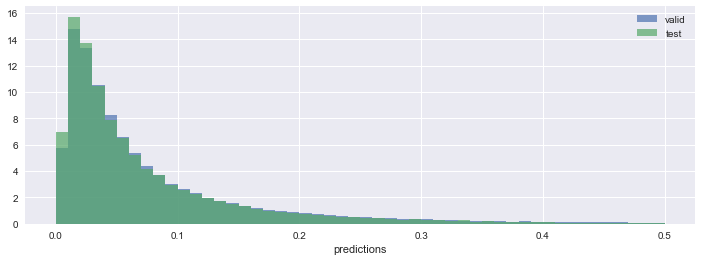

In [146]:
plt.figure(figsize=(12, 4))

plt.hist(preds_mean(dict_preds_blended_valid), bins=50, label='valid', 
         normed=True, alpha=0.7, range=(0, 0.5))
plt.hist(preds_mean(dict_preds_blended_test), bins=50, label='test', 
         normed=True, alpha=0.7, range=(0, 0.5))

plt.xlabel('prediction')
plt.ylabel('Count (normed)')
plt.legend()

plt.show()

In [19]:
submission = pd.read_csv(path + 'sample_submission.csv.zip')['SK_ID_CURR'].to_frame().copy()

submission.loc[:, 'TARGET'] = preds_mean(dict_preds_blended_test)

submission[['SK_ID_CURR', 'TARGET']].to_csv('submission_blend_{:0.4f}.csv.gz'.format(score),
                                            compression='gzip', index=False)

## Blend with NeptuneML OpenSolution

In [28]:
preds_neptune_valid = pd.read_csv('predictions/neptune_valid.csv') \
    .pivot(index='SK_ID_CURR', values='lightGBM_prediction', columns='fold_id').mean(axis=1)
preds_neptune_test = pd.read_csv('predictions/neptune_test.csv') \
    .pivot(index='SK_ID_CURR', values='lightGBM_prediction', columns='fold_id').mean(axis=1)

print('Mean of predictions (train):\t', np.mean(preds_neptune_valid))
print('Mean of predictions (test):\t', np.mean(preds_neptune_test))

score_neptune = roc_auc_score(y, preds_neptune_valid)
print('AUC: {:0.4f} (neptune)'.format(score_neptune))

Mean of predictions (train):	 0.07977527939137002
Mean of predictions (test):	 0.07381664846712335
AUC: 0.7952 (neptune)


In [27]:
weights_neptune = [1.0, 1.0]

preds_blended_neptune_valid = np.average([preds_mean(dict_preds_blended_valid), preds_neptune_valid],
                                         weights=weights_neptune, axis=0)
preds_blended_neptune_test = np.average([preds_mean(dict_preds_blended_test), preds_neptune_test],
                                        weights=weights_neptune, axis=0)

score_blended_neptune_valid = roc_auc_score(y, preds_blended_neptune_valid)
print('AUC: {:0.4f} (blended)'.format(score_blended_neptune_valid))

AUC: 0.7979 (blended)


In [149]:
submission = pd.read_csv(path+'sample_submission.csv.zip')['SK_ID_CURR'].to_frame().copy()
submission.loc[:, 'TARGET'] = preds_blended_neptune_test

submission[['SK_ID_CURR', 'TARGET']] \
    .to_csv('submission_blend_{:0.4f}_blended_with_neptuneOS_{:0.4f}.csv.gz'\
                .format(score, score_blended_neptune_valid),
            compression='gzip', index=False)